# 1. Data Overview

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from category_encoders.binary import BinaryEncoder

In [2]:
df_users = pd.read_csv('/Users/yumin/Documents/NTU/Y2S1/Datathon/Datasets/sd254_users.csv')

In [3]:
df_trans = pd.read_csv('/Users/yumin/Documents/NTU/Y2S1/Datathon/Datasets/credit_card_transactions-ibm_v2.csv')

In [4]:
df_users.head()

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [5]:
df_trans.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [6]:
unique_Users = df_trans['User'].unique()
selected_cards = pd.Series(unique_Users).sample(frac=0.4, replace=False, random_state=42)
filtered_transactions = df_trans[df_trans['User'].isin(selected_cards)]

In [7]:
df = filtered_transactions.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9688065 entries, 28882 to 24382138
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 1.2+ GB


In [8]:
df.shape

(9688065, 15)

In [9]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
28882,2,0,2009,9,26,01:56,$948.44,Online Transaction,3694722044710185708,ONLINE,NaN,NaN,4722,NaN,No
28883,2,0,2009,10,1,04:13,$42.98,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,No
28884,2,0,2009,10,1,10:49,$9.85,Swipe Transaction,-4891055843221560993,West Covina,CA,91792.0,5411,NaN,No
28885,2,0,2009,10,1,14:30,$36.39,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,No
28886,2,0,2009,10,2,04:25,$56.60,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,No


In [10]:
# Check the number of fradulent transactions
df['Is Fraud?'].value_counts()

Is Fraud?
No     9676336
Yes      11729
Name: count, dtype: int64

In [11]:
# Check missing value by column
df.isnull().sum()

User                    0
Card                    0
Year                    0
Month                   0
Day                     0
Time                    0
Amount                  0
Use Chip                0
Merchant Name           0
Merchant City           0
Merchant State    1132934
Zip               1197293
MCC                     0
Errors?           9532311
Is Fraud?               0
dtype: int64

# 2. Data Cleaning

In [12]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
28882,2,0,2009,9,26,01:56,$948.44,Online Transaction,3694722044710185708,ONLINE,NaN,NaN,4722,NaN,No
28883,2,0,2009,10,1,04:13,$42.98,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,No
28884,2,0,2009,10,1,10:49,$9.85,Swipe Transaction,-4891055843221560993,West Covina,CA,91792.0,5411,NaN,No
28885,2,0,2009,10,1,14:30,$36.39,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,No
28886,2,0,2009,10,2,04:25,$56.60,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,No


1. Amount - need to strip the '$' from the Amount to cast as a float
2. Time - Extract the hour and minute to perform a more refined time series analysis
3. Is Fraud? - change the boolean to binary

In [13]:
df['Amount'] = df['Amount'].str.replace('$','').astype(float)

In [14]:
df['Hour'] = df['Time'].str[0:2]
df['Minute'] = df['Time'].str[3:5]
df = df.drop(['Time'], axis=1)

In [15]:
df['Is Fraud?'] = df['Is Fraud?'].apply(lambda x: 1 if x == 'Yes' else 0)

In [16]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
28882,2,0,2009,9,26,948.44,Online Transaction,3694722044710185708,ONLINE,NaN,NaN,4722,NaN,0,01,56
28883,2,0,2009,10,1,42.98,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,0,04,13
28884,2,0,2009,10,1,9.85,Swipe Transaction,-4891055843221560993,West Covina,CA,91792.0,5411,NaN,0,10,49
28885,2,0,2009,10,1,36.39,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,0,14,30
28886,2,0,2009,10,2,56.60,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,0,04,25


# 3. Exploratory Data Analysis

In [17]:
fraud_data=df[df['Is Fraud?']==1]

/Users/yumin/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


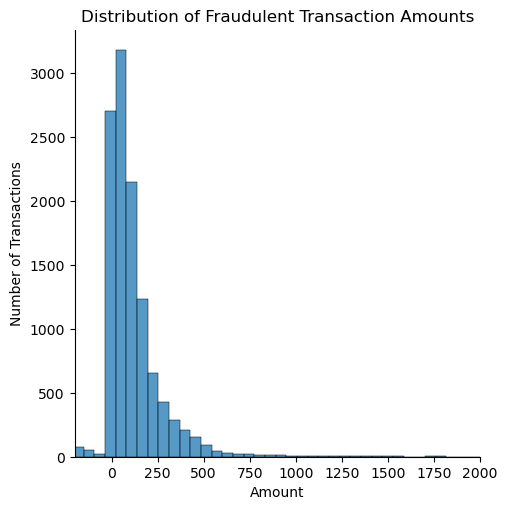

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(fraud_data['Amount'].astype(float), kde=False, bins=80)
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim(-200, 2000)
plt.show()

## Majority of fradulent transactions' amount range from 0 to 250

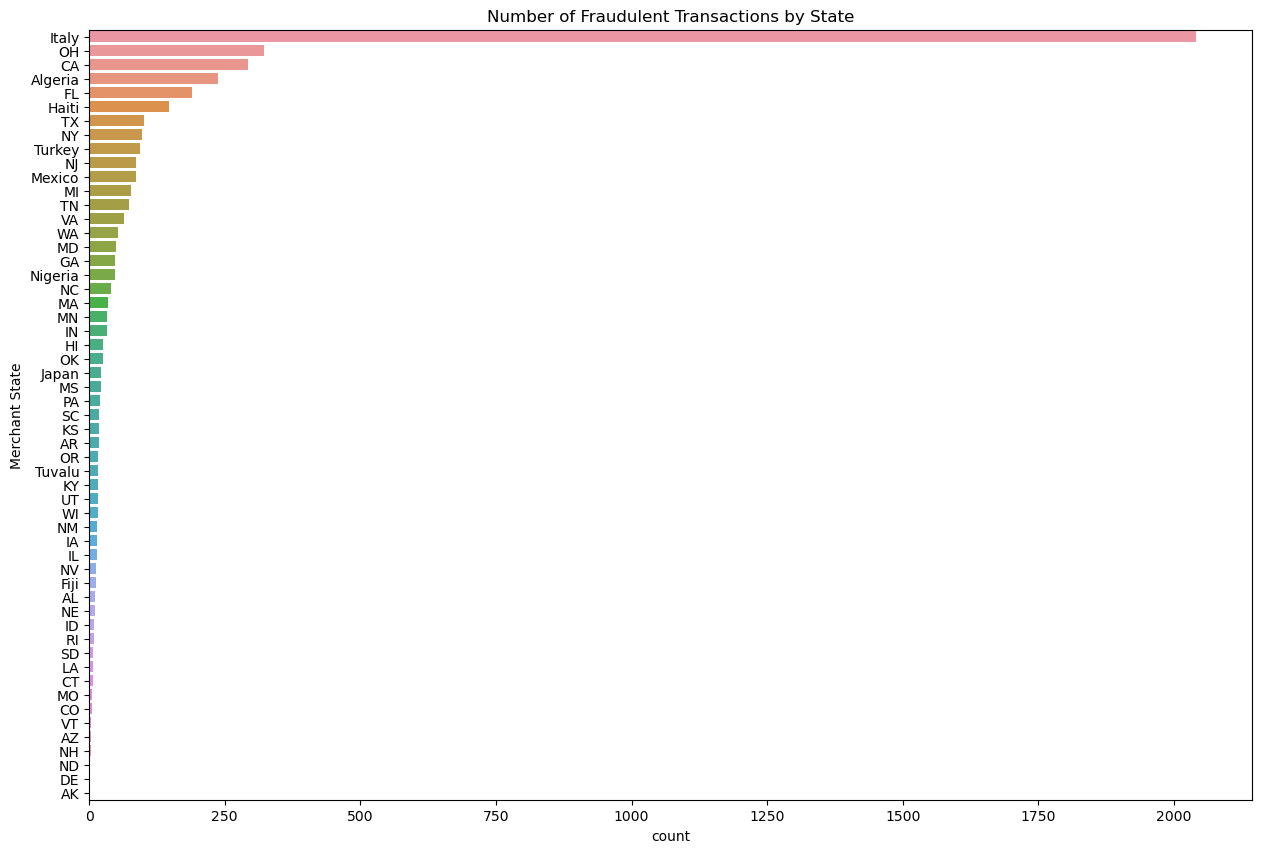

In [19]:
plt.figure(figsize=(15, 10))  
sns.countplot(data=fraud_data, y='Merchant State', order=fraud_data['Merchant State'].value_counts().index)
plt.title('Number of Fraudulent Transactions by State')
plt.show()

## Italy, Algeria, Haiti, and Mexico are the major hotspot for fradulent activities
## Among US states, Ohio, California, and FLorida records the highest incidences of fraud.

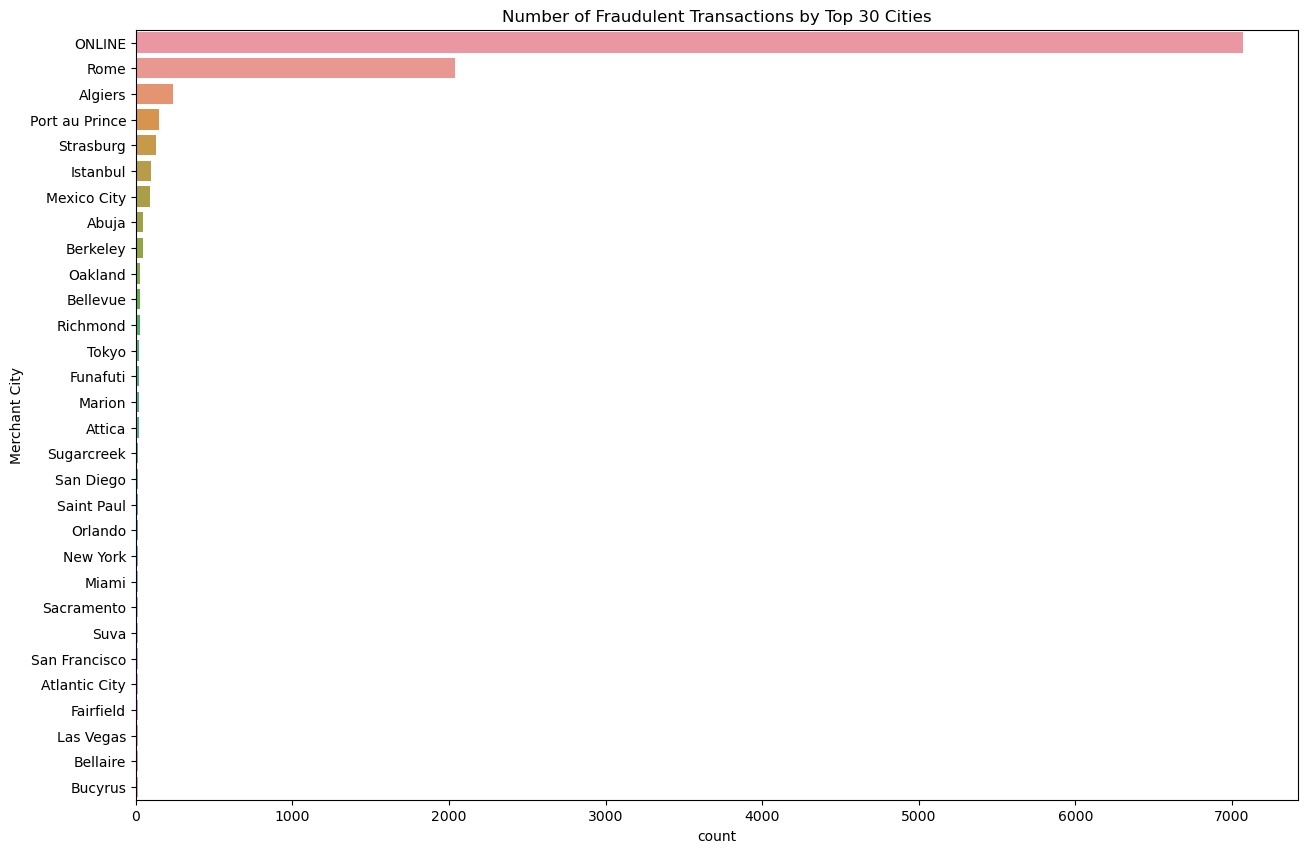

In [20]:
plt.figure(figsize=(15, 10))
top_cities = fraud_data['Merchant City'].value_counts().head(30).index
sns.countplot(data=fraud_data, y='Merchant City', order=top_cities)
plt.title('Number of Fraudulent Transactions by Top 30 Cities')
plt.show()

## Online transactions are the primary venues where fraud predominantly occurs. Additionally, cities such as Rome, Algiers, and Port-au-Prince

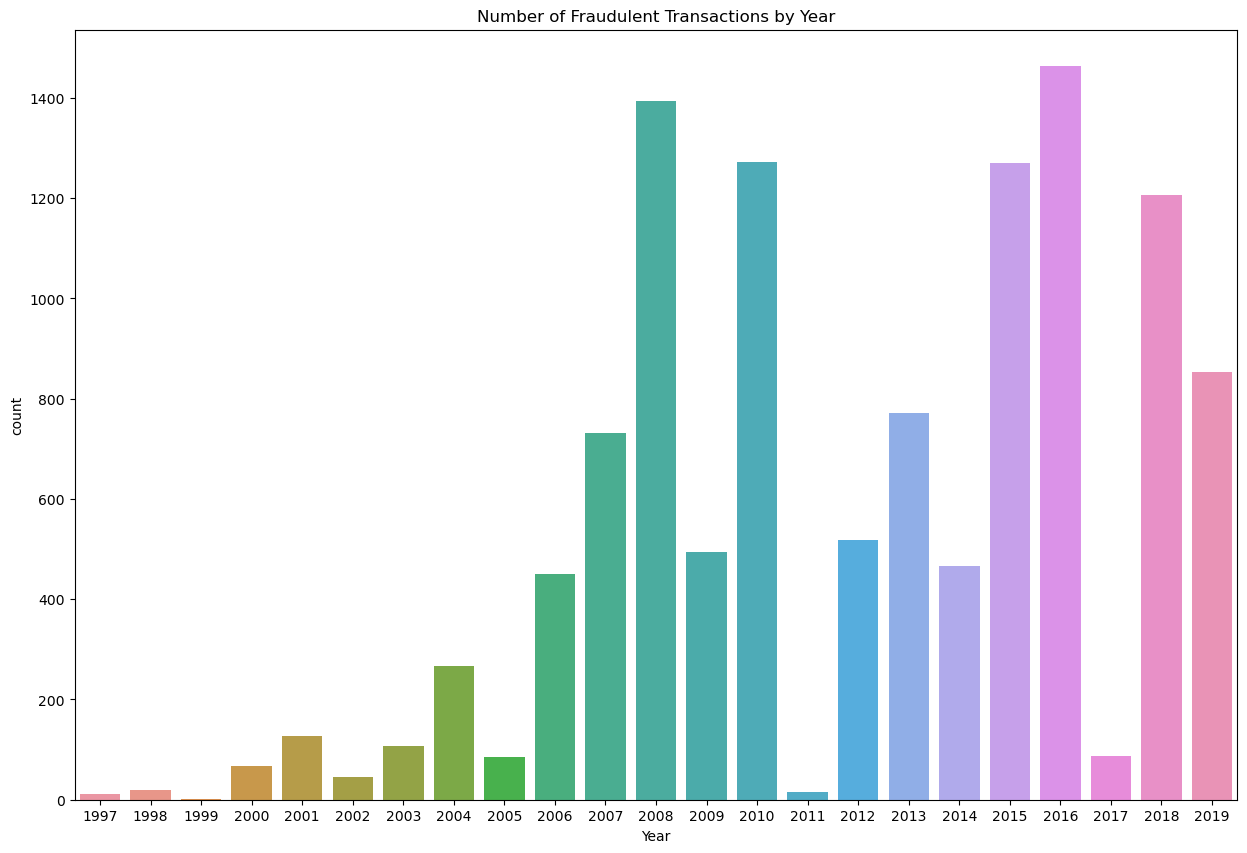

In [21]:
plt.figure(figsize=(15, 10))
sns.countplot(data=fraud_data, x='Year')
plt.title('Number of Fraudulent Transactions by Year')
plt.show()

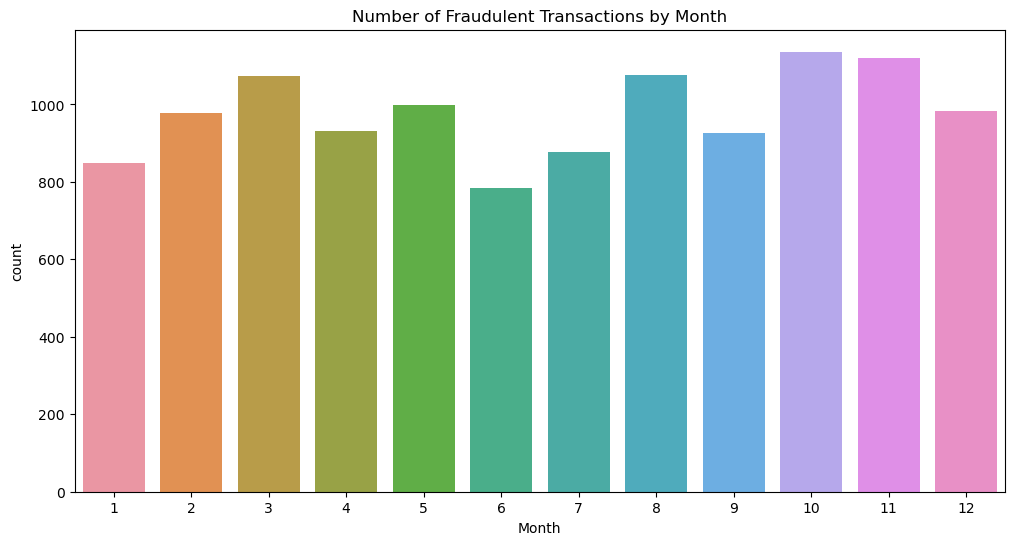

In [22]:
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x='Month')
plt.title('Number of Fraudulent Transactions by Month')
plt.show()

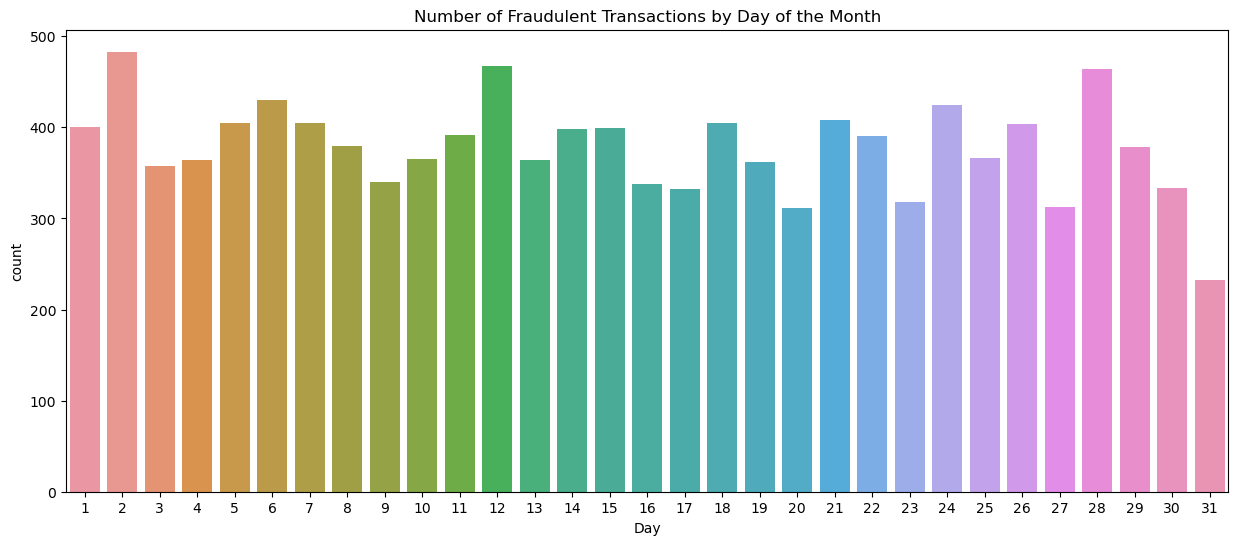

In [23]:
plt.figure(figsize=(15, 6))
sns.countplot(data=fraud_data, x='Day')
plt.title('Number of Fraudulent Transactions by Day of the Month')
plt.show()

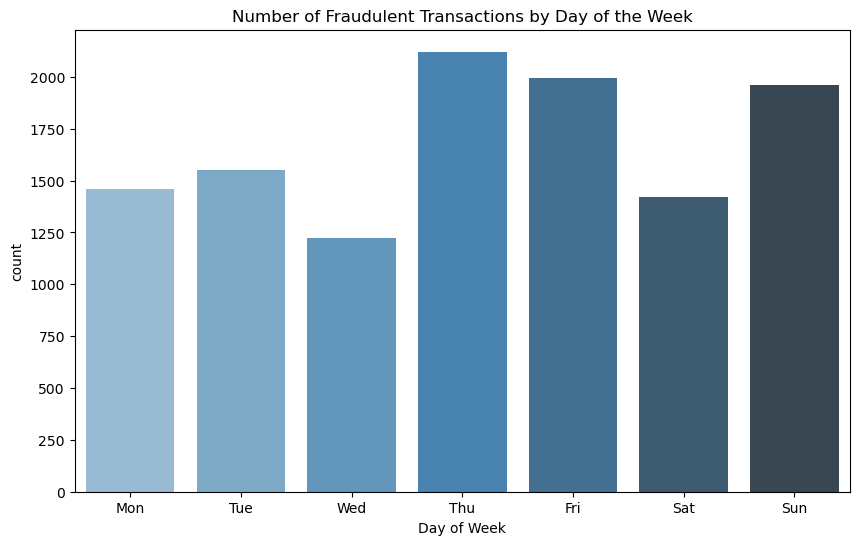

In [24]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Extract day of the week and map it to its name
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['Day of Week'] = df['Date'].dt.dayofweek.map(days)

fraud_data = df[df['Is Fraud?'] == 1]

# Visualize
plt.figure(figsize=(10, 6))
sns.countplot(data=fraud_data, x='Day of Week', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], palette="Blues_d")
plt.title('Number of Fraudulent Transactions by Day of the Week')
plt.show()

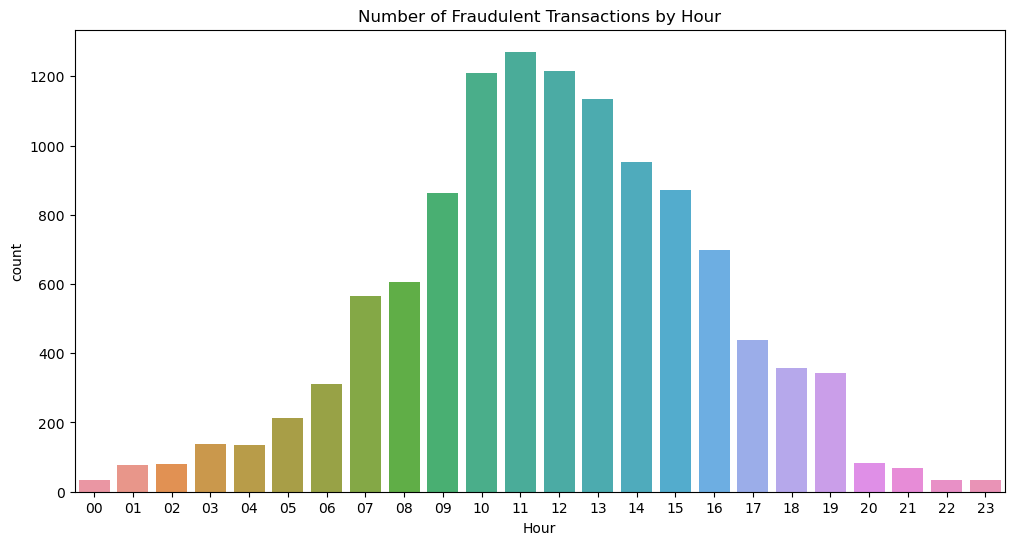

In [25]:
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x='Hour', order=sorted(fraud_data['Hour'].unique()))
plt.title('Number of Fraudulent Transactions by Hour')
plt.show()

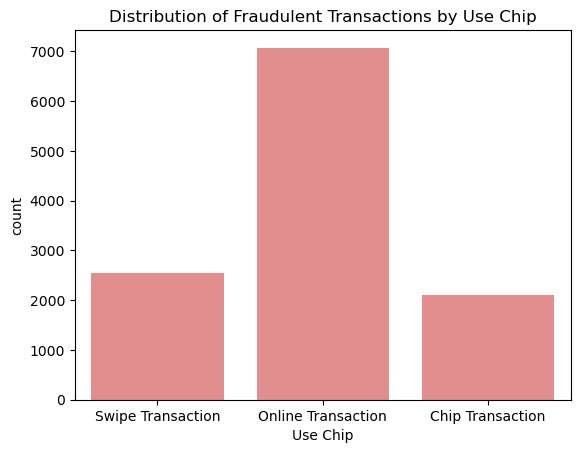

In [26]:
sns.countplot(data=fraud_data, x='Use Chip', color='lightcoral')
plt.title('Distribution of Fraudulent Transactions by Use Chip')
plt.show()

# Data Preprocessing

In [27]:
columns_to_select = ['Year', 'Day of Week', 'Hour', 'Amount', 'Use Chip', 'Merchant Name', 'MCC', 'Is Fraud?']
df = df[columns_to_select]

In [28]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

def clean(df):
    # Convert data type
    df['Hour'] = df['Hour'].astype('float')
    
    # Scale the "Amount" column
    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df[['Amount']])
   
    # Binary encoding for categorical variables
    cat_col = ['Use Chip', 'Day of Week']
    for col in cat_col:
        if col in df.columns:
            be = ce.BinaryEncoder(drop_invariant=False)
            enc_df = pd.DataFrame(be.fit_transform(df[col]), dtype='int8')
            df = pd.concat([df, enc_df], axis=1)
            df.drop([col], axis=1, inplace=True)
    
    for col in df.columns:
        df[col] = df[col].astype(float)
        
    return df

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean, validate=False)), 
], verbose=True)

df_transformed = preprocessing_pipeline.fit_transform(df)

[Pipeline] .......... (step 1 of 1) Processing cleaning, total=   6.4s


In [29]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = df_transformed.drop(columns=['Is Fraud?'])
y = df_transformed['Is Fraud?']

# Calculate the desired number of fraud cases based on the desired proportion
desired_proportion = 0.2
total_samples = 40000
fraud_samples = int(total_samples * desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples}, random_state=1613)

# Apply random undersampling to the original dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1613)

# Logistic Regression

In [30]:
import shap
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=600)
rfe = RFE(estimator=model, n_features_to_select=4)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
X_train_list = X_train.columns.values.tolist()
features = {'Features': X_train_list,'Selected Features':fit.support_ ,'Feature Ranking':fit.ranking_}
rfe_df = pd.DataFrame(features)
rfe_df

Num Features: 4


,Features,Selected Features,Feature Ranking
0,Year,True,1
1,Hour,True,1
2,Amount,False,6
3,Merchant Name,True,1
4,MCC,True,1
5,Use Chip_0,False,2
6,Use Chip_1,False,7
7,Day of Week_0,False,3
8,Day of Week_1,False,5
9,Day of Week_2,False,4


# Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_dpt = DecisionTreeClassifier()

In [39]:
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
grid = GridSearchCV(tree_dpt, tree_param, scoring='recall')
grid.fit(X_train,y_train)
grid.best_params_

{'criterion': 'entropy', 'max_depth': 70}

In [40]:
tree_dpt2 = DecisionTreeClassifier(criterion='entropy',max_depth = 120)
tree_dpt2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=120)

In [41]:
from sklearn.tree import plot_tree

[Text(0.4099437666137189, 0.9838709677419355, 'Use Chip_0 <= 0.5\nentropy = 0.722\nsamples = 28000\nvalue = [22392, 5608]\nclass = N'),
 Text(0.09842514101400415, 0.9516129032258065, 'MCC <= 4972.5\nentropy = 0.991\nsamples = 6002\nvalue = [2665, 3337]\nclass = Y'),
 Text(0.04501642461964039, 0.9193548387096774, 'MCC <= 4116.5\nentropy = 0.935\nsamples = 3281\nvalue = [2131, 1150]\nclass = N'),
 Text(0.04432486168741356, 0.8870967741935484, 'entropy = 0.0\nsamples = 571\nvalue = [0, 571]\nclass = Y'),
 Text(0.04570798755186722, 0.8870967741935484, 'Amount <= 0.382\nentropy = 0.748\nsamples = 2710\nvalue = [2131, 579]\nclass = N'),
 Text(0.033929806362378974, 0.8548387096774194, 'MCC <= 4821.5\nentropy = 0.517\nsamples = 2049\nvalue = [1812, 237]\nclass = N'),
 Text(0.028786307053941907, 0.8225806451612904, 'MCC <= 4753.0\nentropy = 0.374\nsamples = 1882\nvalue = [1746, 136]\nclass = N'),
 Text(0.021957123098201935, 0.7903225806451613, 'MCC <= 4126.0\nentropy = 0.673\nsamples = 662\nval

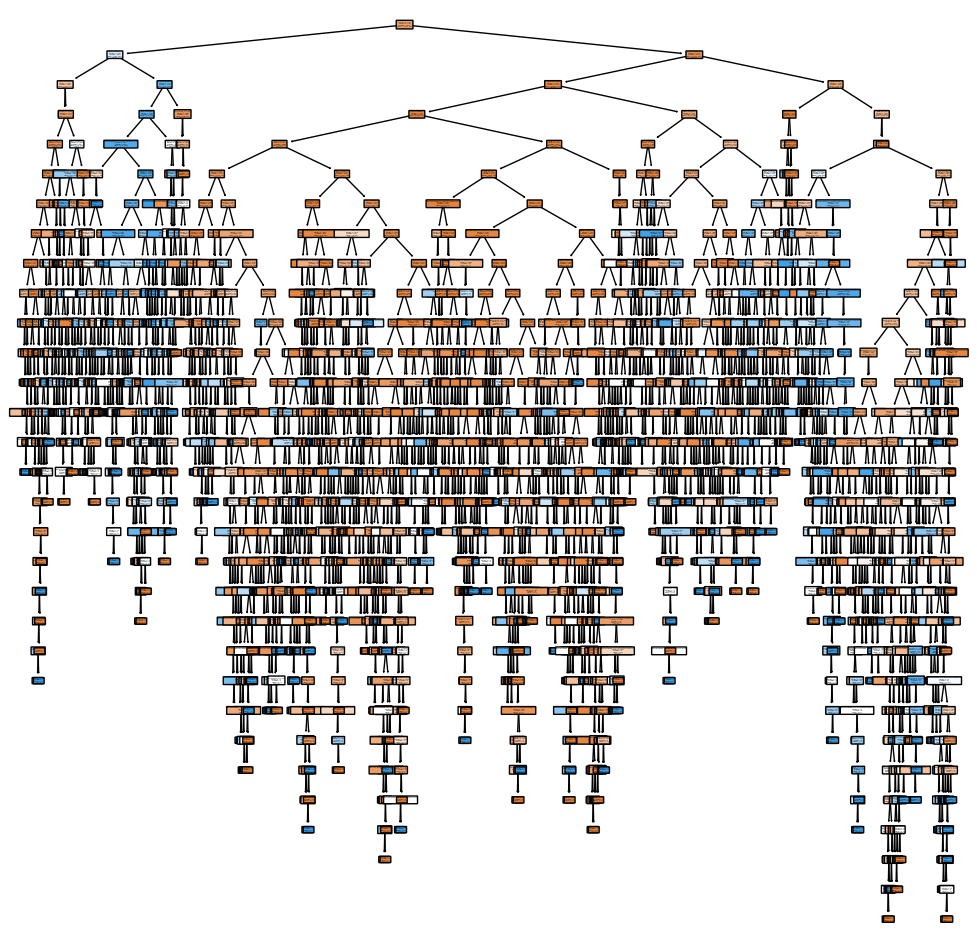

In [42]:
f = plt.figure(figsize=(12,12))
plot_tree(tree_dpt2, filled=True, rounded=True,
         feature_names=X_train.columns,
         class_names=["N", "Y"])

In [43]:
y_pred = tree_dpt2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      9608
         1.0       0.79      0.81      0.80      2392

    accuracy                           0.92     12000
   macro avg       0.87      0.88      0.88     12000
weighted avg       0.92      0.92      0.92     12000



In [44]:
f_imp1 = pd.DataFrame(columns = ['feature', 'importance'], index = range(10))
for i in range(len(f_imp1.index)):
    f_imp1.iloc[i, 0] = X_train.columns.to_list()[i]
f_imp1['importance'] =tree_dpt2.feature_importances_
f_imp1 = f_imp1.sort_values('importance', ascending = False)
f_imp1[0:12].style.background_gradient(cmap = 'Blues')

,feature,importance
4,MCC,0.295093
5,Use Chip_0,0.184950
2,Amount,0.156914
3,Merchant Name,0.126582
0,Year,0.106378
1,Hour,0.091622
9,Day of Week_2,0.013286
8,Day of Week_1,0.011601
7,Day of Week_0,0.010523
6,Use Chip_1,0.003052


## For this decision tree, the 2 most important features are: MCC and Use Chip_0
## Confusion Matrix

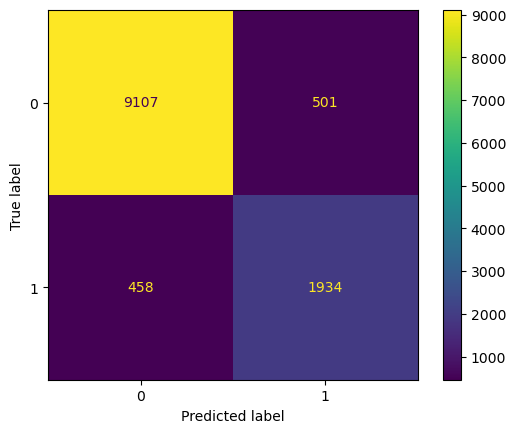

In [45]:
from sklearn import metrics
y_pred = tree_dpt2.predict(X_test)

dt_cm = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = dt_cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

# Random Forest

In [46]:
from sklearn.model_selection import GridSearchCV

n_estimators =[64,100,128,200]
max_features = [2,3,5,7]
bootstrap = [True,False]

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap}

In [47]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=10)
fit = model.fit(X_train, y_train)

## GridSearch to determine best hyperparameters
### Grid-search is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions.

In [48]:
grid = GridSearchCV(rfc,param_grid, scoring='recall')

In [49]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=10),
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 5, 7],
                         'n_estimators': [64, 100, 128, 200]},
             scoring='recall')

In [50]:
grid.best_params_

{'bootstrap': False, 'max_features': 7, 'n_estimators': 100}

### The best parameters are bootstrap=False, max_features=7, n_estimators=200

In [51]:
rfc = RandomForestClassifier(max_features=3,n_estimators=200,bootstrap=True)

In [52]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features=3, n_estimators=200)

In [53]:
rfc.score(X_test, y_test)

0.94425

In [54]:
y_pred = rfc.predict(X_test)

In [55]:
f_imp2 = pd.DataFrame(columns = ['feature', 'importance'], index = range(10))
for i in range(len(f_imp2.index)):
    f_imp2.iloc[i, 0] = X_train.columns.to_list()[i]
f_imp2['importance'] =rfc.feature_importances_
f_imp2 = f_imp2.sort_values('importance', ascending = False)
f_imp2[0:12].style.background_gradient(cmap = 'Blues')

,feature,importance
4,MCC,0.222941
2,Amount,0.189707
3,Merchant Name,0.149947
5,Use Chip_0,0.146413
0,Year,0.116220
1,Hour,0.088509
6,Use Chip_1,0.047660
9,Day of Week_2,0.013896
7,Day of Week_0,0.012382
8,Day of Week_1,0.012323


## Random Forest picked up: MCC, Amount, and Merchant Name as top important features

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      9608
         1.0       0.93      0.78      0.85      2392

    accuracy                           0.94     12000
   macro avg       0.94      0.88      0.91     12000
weighted avg       0.94      0.94      0.94     12000



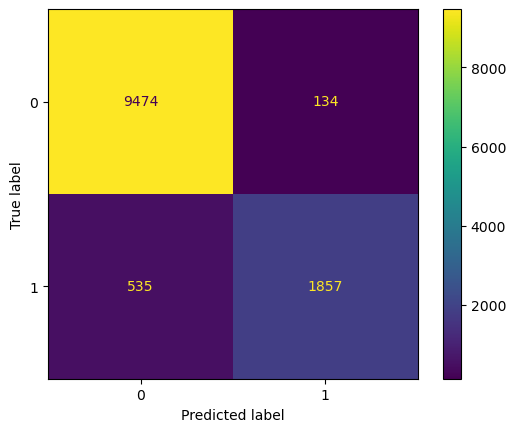

In [58]:
y_pred = rfc.predict(X_test)

dt_cm = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = dt_cm, display_labels = [0, 1])
cm_display.plot()
plt.show()